In [1]:
"importing modules"

import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import random
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

"functions"



'functions'

In [2]:
# path to arealstatistik data
folder_as = 'data/arealstatistik/'


# read in arealstatistik 2004 land cover data and drop unnecessary columns
fname_as2004 = 'AREA_NOLC04_27_130918.csv'
df_as2004 = pd.read_csv(f'{folder_as}{fname_as2004}',';')
df_as2004 = df_as2004[['X','Y','FJ09','LC09_6','LC09_27']]
df_as2004 = df_as2004.rename(columns={'FJ09':'fy', 'LC09_6':'lc_6', 'LC09_27':'lc_27'})


# read in arealstatistik 2013 land cover data, rename columns and drop na ones
df_as2013 = pd.read_csv(f'{folder_as}AREA_Interpretationsresultate.csv', nrows=5000000)
df_as2013 = df_as2013[['X_COORD','Y_COORD','FJ4','LC4_6','LC4_27']]
df_as2013 = df_as2013.rename(columns={'X_COORD':'X', 'Y_COORD':'Y', 'FJ4':'fy', 'LC4_6':'lc_6', 'LC4_27':'lc_27'})
df_as2013 = df_as2013.dropna(axis=0,how='any')

In [3]:
df_as2004.head()

,X,Y,fy,lc_6,lc_27
0,485500,109700,2004,40,41
1,485500,109800,2004,40,41
2,485500,109900,2004,40,41
3,485500,110000,2004,40,41
4,485500,110100,2004,40,41


In [4]:
df_as2013.head()

,X,Y,fy,lc_6,lc_27
0,488900,112700,2012.0,10.0,11.0
1,489000,111400,2012.0,40.0,47.0
2,490700,116700,2012.0,10.0,11.0
3,491100,114500,2012.0,20.0,21.0
4,491200,117800,2012.0,40.0,46.0


In [6]:


def remap(lc6,lc27):
    def fun(row):
    
        remap_dict1 = {10: 0, 20: 1, 30: 2, 40: 3, 50: 4}
        remap_dict2 = {61: 5, 62: 6, 63: 1, 64: 1}
    
        # everything but 'watery areas' (60) is simply remapped
        if row[lc6] < 60:
            return remap_dict1.get(int(row[lc6]))
        else: # watery areas
            return remap_dict2.get(int(row[lc27]))    
        # end of remap function

    return fun


 # apply function to data frames
df_as2004['land_cover'] = df_as2004.apply(remap('lc_6','lc_27'), axis=1)
df_as2013['land_cover'] = df_as2013.apply(remap('lc_6','lc_27'), axis=1)

In [7]:
df_as2004.head()

,X,Y,fy,lc_6,lc_27,land_cover
0,485500,109700,2004,40,41,3
1,485500,109800,2004,40,41,3
2,485500,109900,2004,40,41,3
3,485500,110000,2004,40,41,3
4,485500,110100,2004,40,41,3


In [8]:
df_as2013.head()

,X,Y,fy,lc_6,lc_27,land_cover
0,488900,112700,2012.0,10.0,11.0,0
1,489000,111400,2012.0,40.0,47.0,3
2,490700,116700,2012.0,10.0,11.0,0
3,491100,114500,2012.0,20.0,21.0,1
4,491200,117800,2012.0,40.0,46.0,3


In [9]:
# convert data frame to a numpy array
def df2arr(df):



    # get indices based on coordinates
    x_min = df['X'].min(); y_min = df['Y'].min()
    df['ix'] = (df['X'] - x_min)//100; df['iy'] = (df['Y'] - y_min)//100

    # create numpy array

    # indices start with 0 => +1 to get number of elemements
    n_columns = df['ix'].max()+1; n_rows = df['iy'].max()+1

    # [n rows, n columns]
    land_cover = np.full((n_rows,n_columns),-1,dtype=int)
    year = np.full((n_rows,n_columns),-1,dtype=int)
    neighbour = np.full((n_rows,n_columns),-1,dtype=int)
    print('shape:',land_cover.shape)

    # transfer data frame data to array
    for index, row in df.iterrows():
    
        land_cover[int(row['iy']),int(row['ix'])] = int(row['land_cover'])
        year[int(row['iy']),int(row['ix'])] = int(row['fy'])
    
        if index%1000000 == 0: print(index)
        # end of loop
    
    # flip numpy array upside-down
    land_cover = np.flip(land_cover,axis=0)
    year = np.flip(year,axis=0)
    neighbour = np.flip(neighbour,axis=0)
    
    
    return land_cover, year, neighbour
    # end of function
    
lc_as2004, fy_as2004, neighbour_as2004 = df2arr(df_as2004)
lc_as2013, fy_as2013, neighbour_as2013 = df2arr(df_as2013)


shape: (2207, 3484)
0
1000000
2000000
3000000
4000000
shape: (1863, 2833)
0
2000000
3000000


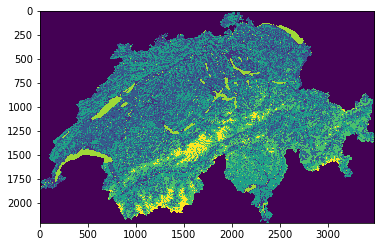

In [10]:
plt.imshow(lc_as2004)

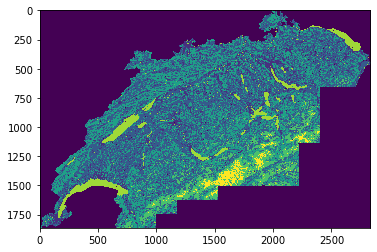

In [11]:
plt.imshow(lc_as2013)

In [ ]:
""" n neighbours is not computed anymore """

# function to determine whether array at given position is homogeneous
def get_n_same_neighbours(array,i_row,i_column):
    
    land_cover_center = array[i_row,i_column]
    
    if land_cover_center == -1:
        return land_cover_center
    else:
        values = []
        for x in range(i_row-1,i_row+2):
            for y in range(i_column-1,i_column+2):
                values.append(array[x,y])
    
        return values.count(land_cover_center)
        # end of else
        
    # end of function

x_coord_column = []
y_coord_column = []
land_cover_column = []
flight_year_column = []
n_neighbours_column = []

# (index row, index column)
for index, x in np.ndenumerate(land_cover):
    
    i_row = index[0]; i_column = index[1]
    
    n_neighbours = -1
    # get number of neighbours but ingore edges of matrix (for edges n_neighbours stays -1)
    if ((i_row>0 and i_row<n_rows-1) and (i_column>0 and i_column<n_columns-1)):
        n_neighbours = get_n_same_neighbours(land_cover,i_row,i_column)

    # only consider non-edges and points with data
    if x != -1:
        x_coord_column.append(int(i_column*100+x_min))
        y_coord_column.append(int(i_row*100+y_min))
        land_cover_column.append(x)
        flight_year_column.append(year[i_row,i_column])
        n_neighbours_column.append(n_neighbours)
        
        neighbour[i_row,i_column] = n_neighbours
    
    if i_column == 0 and i_row%100 == 0: print(index)
    # end of loop


data = {
    'X': x_coord_column,
    'Y': y_coord_column[::-1],
    'land_cover': land_cover_column,
    'FJ09': flight_year_column,
    'n_neigh': n_neighbours_column
}


data_df = pd.DataFrame(data,columns=['X','Y','land_cover','FJ09','n_neigh'])

In [ ]:
# export as csv data frame

data_df.to_csv(f'{folder_as}as_preprocessed.csv', encoding='utf-8', index=False)


# export as shape file

import geopandas as gpd
from shapely.geometry import Point

# combine x and y column to a shapely Point() object
data_df['geometry'] = data_df.apply(lambda x: Point((float(x.X), float(x.Y))), axis=1)

# creating geo data frame and changing the crs to utm zone N32
gdf = gpd.GeoDataFrame(data_df, geometry='geometry')
gdf.crs = {'init': 'epsg:21781'}
# UTM Zone 32N: epsg:32632, WG84: epsg:4326
# gdf = gdf.to_crs({'init': 'epsg:4326'})

# exporting geo data frame as shapefile
gdf.to_file(f'{folder_as}as2004_reference_data.shp', driver='ESRI Shapefile')

In [12]:
def geotransform_from_df(df):
    
    # get coordinates
    x_min, x_max, y_min, y_max = [df['X'].min(), df['X'].max(), df['Y'].min(), df['Y'].max()]
    n_rows, n_cols = np.shape(land_cover)
    x_res, y_res = (100, 100)
    geotransform = (x_min-50, x_res, 0, y_max+50, 0, -y_res)
    
    return geotransform

# export array as geo tiff file



# function to export a numpy array (arr) as geo tiff
def arr2geotiff(arr, geotransform, file_name):
    
    n_rows, n_cols = np.shape(arr)
    
    # open geo tiff file
    output_raster = gdal.GetDriverByName('GTiff').Create(file_name+'.tif',n_cols, n_rows, 1, gdal.GDT_Int16)
    output_raster.SetGeoTransform(geotransform)
    
    # set crs
    srs = osr. SpatialReference()
    srs.ImportFromEPSG(21781)
    output_raster.SetProjection(srs.ExportToWkt())
    
    # write array to geo tiff
    output_raster.GetRasterBand(1).WriteArray(arr)
    output_raster.FlushCache()
    
    # end of export geo tiff function

    



In [23]:
x_min, x_max = [485500, 833800]
y_min, y_max = [75300, 295900]


# create region of interests
def getX_index(x_coord):
    return int((x_coord-x_min)/100)

def getY_index(y_coord):    
    return int((y_max-y_min)/100-(y_coord-y_min)/100)

def getX_coord(x_index):
    return int(x_index*100+x_min)

def getY_coord(y_index):
    return int((y_min+y_max)-(y_index*100+y_min))

print(getX_coord(getX_index(x_min)))
print(getX_coord(getX_index(x_max)))

print(getY_coord(getY_index(y_min)))
print(getY_coord(getY_index(y_max)))

    

485500
833800
75300
295900


In [24]:
rois = ['roi1','roi2','roi3']


# width and height of a region of interest
roi_width = 230
roi_height = 150

# coordinates of the top left point of a region of interest
tl_coords_roi1 = (667600, 252600)
tl_coords_roi2 = (630000, 190000)
# tl_coords_roi3 = (580800, 108800)
tl_coords_roi3 = (576000, 137000)

tl_coords = [tl_coords_roi1,tl_coords_roi2,tl_coords_roi3]
tl_indices = [(getX_index(coords[0]),getY_index(coords[1])) for coords in tl_coords]

In [25]:

def plot_roi(arr,tl_indices,width,height,fig_name='roi'):
    
    classes = ['No data', 'Artificial areas', 'Grass and herb vegetation', 'Brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
    hex_colors = ['#FFFFFF',"#FF0000","#FFFF00","#B2B200","#00B200","#804D33",'#0000FF','#B2B2B2']
    cmap = mpl.colors.ListedColormap(hex_colors[1:])
    norm = mpl.colors.BoundaryNorm(np.arange(-0.5,7), cmap.N)
        
    roi = arr[tl_indices[1]:tl_indices[1]+height,tl_indices[0]:tl_indices[0]+width]
        
    fig, ax = plt.subplots(figsize=(10,10))        
    im = ax.imshow(roi, cmap=cmap, norm=norm)

    x_indices = np.linspace(tl_indices[0],tl_indices[0]+width,5)
    x_ticks = [int(x-tl_indices[0]) for x in x_indices]
    plt.xticks(x_ticks,[getX_coord(x_index) for x_index in x_indices])

    y_indices = np.linspace(tl_indices[1],tl_indices[1]+height,5)
    y_ticks = [int(y-tl_indices[1]) for y in y_indices]
    plt.yticks(y_ticks,[getX_coord(y_index) for y_index in y_indices])

    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_title(fig_name)

    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="5%", pad=0.4, pack_start=False)
    fig.add_axes(cax)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical", ticks=np.linspace(0,7,8))
    cbar.ax.set_yticklabels(classes[1:])

    plt.savefig(fig_name+'.png',dpi=300)
    plt.show()

    # end of plot roi function
    
def stats_roi(arr,tl_indices,width,height,fig_name='roi'):
    
    data = arr[tl_indices[1]:tl_indices[1]+height,tl_indices[0]:tl_indices[0]+width]
    data_hist = data.flatten().tolist()
    # print(data_hist.count(6))
    bins = np.arange(-0.5, 7.5, 1) # fixed bin size
    classes = ['No data', 'Artificial areas', 'Grass and herb vegetation', 'Brush vegetation', 'Tree vegetation', 'Bare land', 'Watery areas', 'Glacier, perpetual snow']
    plt.ylim([-0.5, 6.5])


    plt.hist(data_hist, bins=bins, color='k', rwidth=0.5,orientation='horizontal')
    plt.title(fig_name)
    plt.xlabel('count')
    plt.yticks(np.arange(0,7,1),classes[1:])

    plt.show()
    
    # end of roi stats function
    
    
def check_flight_year(arr,tl_indices,width,height):
    
    data = arr[tl_indices[1]:tl_indices[1]+height,tl_indices[0]:tl_indices[0]+width]
    data_hist = data.flatten().tolist()
    
    unique_values = list(set(data_hist))
    hist = {}
    for value in unique_values:
        hist[value] = data_hist.count(value)
    
    return hist
    # end of check flight year function


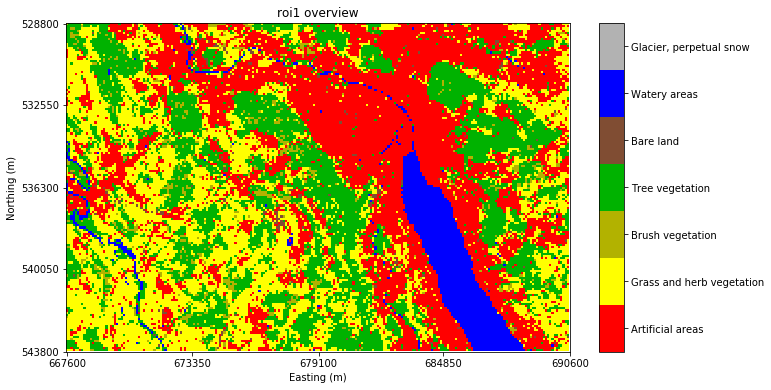

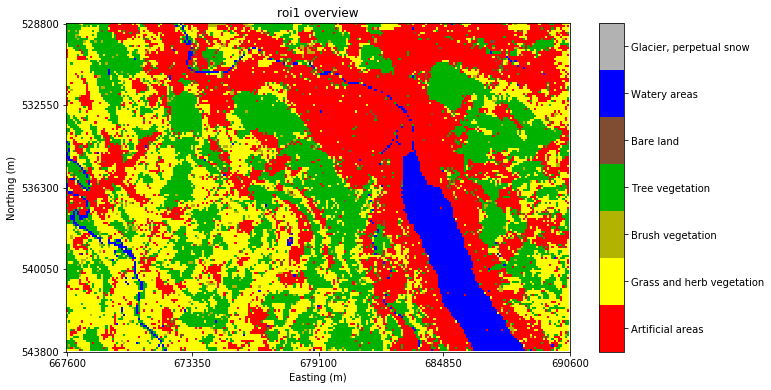

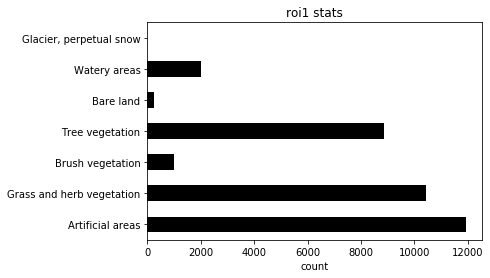

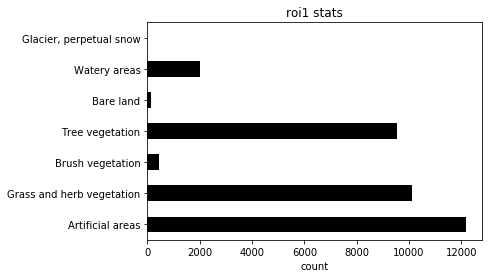

{2007: 34500}
{2016: 34439, -1: 61}


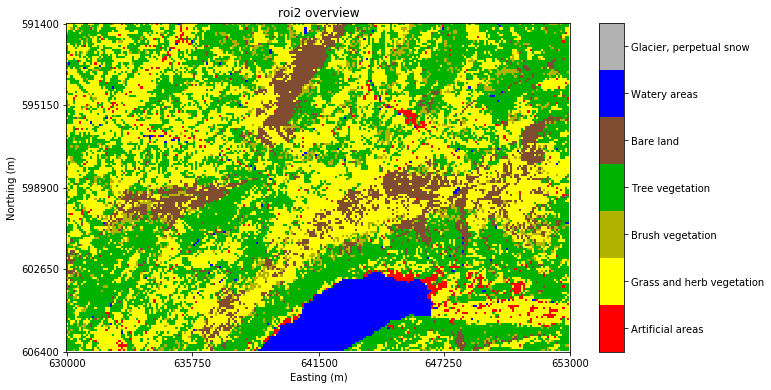

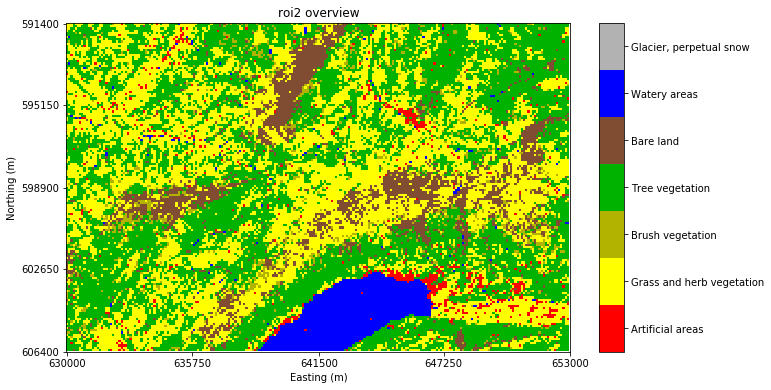

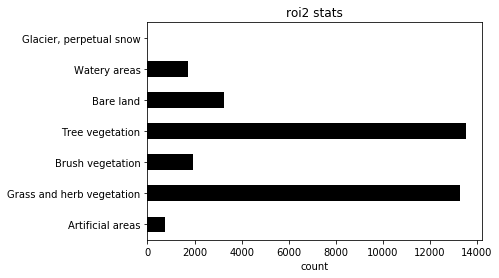

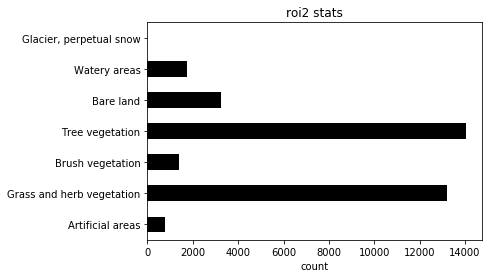

{2006: 34500}
{-1: 69, 2015: 34431}


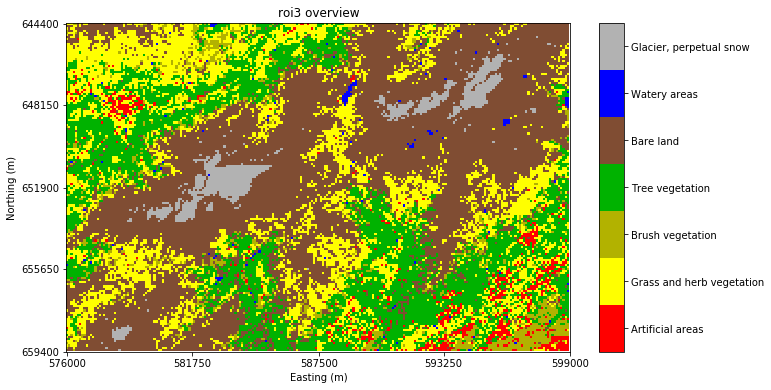

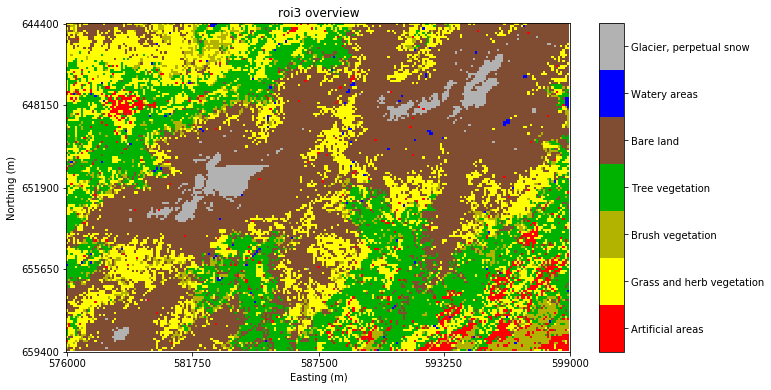

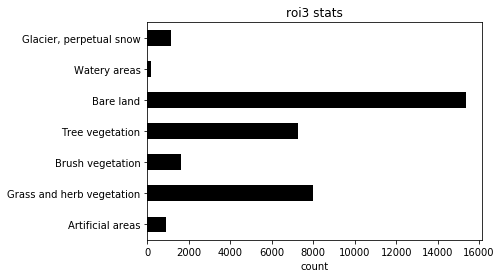

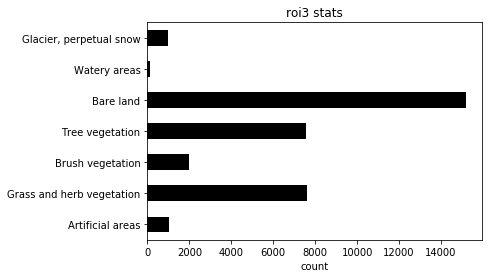

{2004: 34500}
{2013: 34429, -1: 71}


In [16]:
for iroi, roi in enumerate(rois):
    
    plot_roi(lc_as2004,tl_indices[iroi],roi_width,roi_height,f'{roi} overview')
    plot_roi(lc_as2013,tl_indices[iroi],roi_width,roi_height,f'{roi} overview')
    
    stats_roi(lc_as2004,tl_indices[iroi],roi_width,roi_height,f'{roi} stats')
    stats_roi(lc_as2013,tl_indices[iroi],roi_width,roi_height,f'{roi} stats')
    
    print(check_flight_year(fy_as2004,tl_indices[iroi],roi_width,roi_height))
    print(check_flight_year(fy_as2013,tl_indices[iroi],roi_width,roi_height))

In [33]:
# exporting regions of interest as shape files and geo tiffs


def convert2polygon(tl_coords, width, height):
    
    tl_x, tl_y = (tl_coords[0]-50, tl_coords[1]+50)
    lr_x = getX_coord(getX_index(tl_x)+width)+50
    lr_y = getY_coord(getY_index(tl_y)+height)-50
    
    tl = Point((float(tl_x),float(tl_y)))
    tr = Point((float(lr_x),float(tl_y)))
    lr = Point((float(lr_x),float(lr_y)))
    ll = Point((float(tl_x),float(lr_y)))
                      
    polygon = Polygon([[p.x,p.y] for p in [tl,tr,lr,ll]])
    print(polygon.wkt)
    
    return polygon


# function to export a region of interest as shape file
def export_shapefile(polygon, file_name):
    
    output_gdf = gpd.GeoDataFrame(pd.DataFrame({'geometry':[polygon]}), geometry='geometry')
    output_gdf.crs = {'init': 'epsg:21781'}
    output_gdf = output_gdf.to_crs({'init': 'epsg:32632'})
    
    output_gdf.to_file(file_name+'.shp', driver='ESRI Shapefile')
    # end of export shape file function

polygons = []
for iroi, roi in enumerate(rois):
    
    geotransform = (tl_coords[iroi][0]-50, 100, 0, tl_coords[iroi][1]+50, 0, -100)
    
    
    polygon = convert2polygon(tl_coords[iroi],roi_width,roi_height)
    export_shapefile(polygon,f'{folder_as}{roi}')
    polygons.append(polygon)
    
    lc_as2004_roi = lc_as2004[tl_indices[iroi][1]:tl_indices[iroi][1]+roi_height,tl_indices[iroi][0]:tl_indices[iroi][0]+roi_width]
    arr2geotiff(lc_as2004_roi,geotransform,f'{folder_as}validation_{roi}_as2004')
    
    lc_as2013_roi = lc_as2013[tl_indices[iroi][1]:tl_indices[iroi][1]+roi_height,tl_indices[iroi][0]:tl_indices[iroi][0]+roi_width]
    arr2geotiff(lc_as2013_roi,geotransform,f'{folder_as}validation_{roi}_as2013')


POLYGON ((667550 252650, 690550 252650, 690550 237650, 667550 237650, 667550 252650))
POLYGON ((629950 190050, 652950 190050, 652950 175050, 629950 175050, 629950 190050))
POLYGON ((575950 137050, 598950 137050, 598950 122050, 575950 122050, 575950 137050))


In [18]:

def sub_df(df,polygon):
    
    df['in_poly'] = df.apply(lambda x: polygon.contains(Point((float(x.X), float(x.Y)))), axis=1)
    df = df[df['in_poly']==True]
    df = df.drop(columns=['in_poly'])
    
    return df
    # end of sub df function
    
    
dfs_rois_as2004 = []
dfs_rois_as2013 = []
for i, (roi,poly) in enumerate(zip(rois,polygons)):
    
    df_as2004_roi = sub_df(df_as2004,poly)
    df_as2004_roi['roi'] = roi
    dfs_rois_as2004.append(df_as2004_roi)
    
    df_as2013_roi = sub_df(df_as2013,poly)
    df_as2013_roi['roi'] = roi
    dfs_rois_as2013.append(df_as2013_roi)


In [28]:
df_rois_as2004 = pd.concat(dfs_rois_as2004,axis=0)
df_rois_as2004 = df_rois_as2004[['roi','X','Y','fy','land_cover']]
print(df_rois_as2004.shape)
df_rois_as2004.to_csv(f'{folder_as}as2004_preprocessed.csv', encoding='utf-8', index=False)

df_rois_as2013 = pd.concat(dfs_rois_as2013,axis=0)
df_rois_as2013 = df_rois_as2013[['roi','X','Y','fy','land_cover']]
print(df_rois_as2013.shape)
df_rois_as2013.to_csv(f'{folder_as}as2013_preprocessed.csv', encoding='utf-8', index=False)



(103500, 5)
(103299, 5)


In [29]:
df_rois_as2004.head()

,roi,X,Y,fy,land_cover
2199011,roi1,667600,237700,2007,1
2199012,roi1,667600,237800,2007,3
2199013,roi1,667600,237900,2007,3
2199014,roi1,667600,238000,2007,3
2199015,roi1,667600,238100,2007,3


In [30]:
df_rois_as2013.head()

,roi,X,Y,fy,land_cover
2122,roi1,667700,246400,2016.0,5
2125,roi1,668300,252000,2016.0,1
2131,roi1,668600,242000,2016.0,1
2136,roi1,669100,241100,2016.0,3
2149,roi1,670300,239000,2016.0,1
